# Text Study

After the initial audio study and the necessary text extraction, the next logical step will be the study of this type of unstructured data.

We will take a look at both the audio transcripts and the captions from the videos, in order to extract as much information as possible to predict the virality of a video.

## First libraries and variables import

In [1]:
import sys
from pathlib import Path
import os
import ast
import numpy as np

# interactive plotting
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
import os
sns.set()

# Get the absolute path of the folder containing the module
root_dir = Path.cwd().resolve().parent.parent

# Add the folder path to sys.path
sys.path.append(str(root_dir))

import nltk
from nltk.tokenize import word_tokenize
from InstructorEmbedding import INSTRUCTOR
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from mltools import regression_tools as RT
from mltools import model_tools as MT

from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics

from transformers import AutoModelForMaskedLM
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from transformers import XLMRobertaConfig

c:\Users\juanl\Documents\Master\2o cuatri\ADNE\Trabajo\Tik Tok\tiktok\Lib\site-packages\InstructorEmbedding\instructor.py:7: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import trange


In [2]:
from text_utils import load_json, load_transcriptions, clean_text, plot_freq_dist, analyze_text, get_bag_of_words, perform_topic_modeling, \
                        classify_sentiment, count_sentiments, concatenate_embeddings, calculate_metrics, count_parameters, CustomDataset
from config.variables import text_path, json_file, csv_file, textcsv_file, model_path

In [3]:
text_folder = os.path.join(root_dir, text_path)
json_path = os.path.join(root_dir, json_file)

## Data recopilation and ordering

In [4]:
# Load the transcriptions of the videos
transcriptions = load_transcriptions(text_folder)

# Load the information from the JSON file
video_info = load_json(json_path)

In [5]:
# Create an object to store the combined information
video_data = {}

# Combine the information from transcriptions and the JSON file
for video_id, info in video_info.items():
    if video_id in transcriptions:
        general = info.get('general', '')  # Get the general information of the video or an empty string if not present
        text = general.get('text', '')  # Get the text of the video or an empty string if not present
        hashtags = general.get('hashtags', [])  # Get the hashtags of the video or an empty list if not present
        video_data[video_id] = {'transcription': transcriptions[video_id], 'text': text, 'hashtags': hashtags}

# Example of accessing the combined information for the first video
first_video = list(video_data.keys())[0]
print("Transcription:", video_data[first_video]['transcription'])
print("Text:", video_data[first_video]['text'])
print("Hashtags:", video_data[first_video]['hashtags'])

Transcription: 
Text: Confidence went 📈
Hashtags: []


In [6]:
# Counting the elements that are not empty strings in transcriptions
transcription_count = sum(1 for trans in transcriptions.values() if trans != '')
print("Number of non-empty transcriptions:", transcription_count)

# Counting the number of elements in video_data where the transcription is not ''
video_data_count_non_empty = sum(1 for video_id, data in video_data.items() if data['transcription'] != '')
print("Number of video_data elements with non-empty transcriptions:", video_data_count_non_empty)

# Counting the elements that are not empty strings in the video text
texts_count = sum(1 for video_id, data in video_data.items() if data['text'] != '')
print("Number of video_data elements with non-empty text:", texts_count)

# Counting the elements that are not empty lists in hashtags
hashtags_count = sum(1 for video_id, data in video_data.items() if data['hashtags'] != [])
print("Number of video_data elements with non-empty hashtags:", hashtags_count)


Number of non-empty transcriptions: 261
Number of video_data elements with non-empty transcriptions: 261
Number of video_data elements with non-empty text: 962
Number of video_data elements with non-empty hashtags: 853


As we can see, we have a transcription for 1 out of 4 videos aprox. Nevertheless, we have text and hashtags for almost all of the videos, so a text strudy could be deployed.

## Text Pre-Processing

### Text cleaning

In [7]:
# text cleaning of transcriptions and text
for video_id, data in video_data.items():
    if 'transcription' in data:
        video_data[video_id]['clean_transcription'] = clean_text(data['transcription'])
    if 'text' in data:
        video_data[video_id]['clean_text'] = clean_text(data['text'])

In [8]:
video_data

{'6907228749016714497': {'transcription': '',
  'text': 'Confidence went 📈',
  'hashtags': [],
  'clean_transcription': '',
  'clean_text': 'confidence went'},
 '6875468410612993286': {'transcription': '',
  'text': 'Quiet Zone... follow me on insta: joeysofo. Comment where you wanna see me blade next. Reply to @dwight_schnuute',
  'hashtags': [],
  'clean_transcription': '',
  'clean_text': 'quiet zone follow insta joeysofo comment wan na see blade next reply'},
 '6898699405898059010': {'transcription': '',
  'text': 'Iphone bend test🤗 #tiktok #viral #fyp #iphone #test #bend',
  'hashtags': ['tiktok', 'viral', 'fyp', 'iphone', 'test', 'bend'],
  'clean_transcription': '',
  'clean_text': 'iphone bend'},
 '6902819837345533186': {'transcription': '',
  'text': '',
  'hashtags': [],
  'clean_transcription': '',
  'clean_text': ''},
 '6905635666588192002': {'transcription': '',
  'text': '小技です👟✨#tiktok教室#tutorial',
  'hashtags': ['tiktok教室', 'tutorial'],
  'clean_transcription': '',
  'cl

In [9]:
for video_id, data in video_data.items():
    
    transcription = video_data[video_id]['clean_transcription']
    text = video_data[video_id]['clean_text']
    
    if transcription == '':
        transcription = 'No transcription'
    if text == '':
        text = 'No text'
        
    hashtags = video_data[video_id]['hashtags']
    
    if hashtags == []:
        hashtags = ['No hashtags']
        
    all_text = f"Transcription: {transcription}. Caption: {text}. Hashtags: {', '.join(hashtags)}."
    video_data[video_id]['all_text'] = all_text
    video_data[video_id]['clean_all_text'] = clean_text(all_text)
    
# Combination of the cleaned text in a single string in order to perform models (second approach)

In [10]:
video_data[list(video_data.keys())[34]]

{'transcription': "is there the top 10 strongest one piece characters by the end of the show at number 10 we have Trafalgar law he can make anyone Immortal at the expense of his life number 9 we have useless kid he challenged kaido even though the odds are against him just like Luffy number 8 we have Sabo even though he's not at his Peak he can challenge fujitora and number 7 we have GARP the only man known to go to Toe with the former pirate king Goldie Rodger number 6 we have a kind of the author himself Oda said that if a kind of was the main character he'd find the one piece in a single year number five we have Shanks at the marineford where he just came in and said war is over and it really ended what else do you need to know about Shanks make sure like for part two",
 'text': '#Top10 Strongest #onepiece Characters by the end of the show. #anime #strongestcharacters #animeboy #luffy #zoro #animeedit #animeedits #animestiktok',
 'hashtags': ['top10',
  'onepiece',
  'anime',
  'str

As we can see, it has occured a tokenization, lemmatization and an elimination of hashtags, punctuation signs, special characters and stopwords for both text and transcription, bearing in mind the language of the possible text and transcription.

### Exploratory analysis

The next step will be the frequency distribution and the word cloud of the clean transcripts and texts, as well as the hashtags (probably the most useful one).

It is important to highlight that the all_text and cleaned all_text sections will not be used, since for exploratory analysis or sentiment analysis it does not make sense to treat the caption, transcript and hashtags as a single entity.

In [11]:
video_data

{'6907228749016714497': {'transcription': '',
  'text': 'Confidence went 📈',
  'hashtags': [],
  'clean_transcription': '',
  'clean_text': 'confidence went',
  'all_text': 'Transcription: No transcription. Caption: confidence went. Hashtags: No hashtags.',
  'clean_all_text': 'transcription transcription caption confidence went hashtags hashtags'},
 '6875468410612993286': {'transcription': '',
  'text': 'Quiet Zone... follow me on insta: joeysofo. Comment where you wanna see me blade next. Reply to @dwight_schnuute',
  'hashtags': [],
  'clean_transcription': '',
  'clean_text': 'quiet zone follow insta joeysofo comment wan na see blade next reply',
  'all_text': 'Transcription: No transcription. Caption: quiet zone follow insta joeysofo comment wan na see blade next reply. Hashtags: No hashtags.',
  'clean_all_text': 'transcription transcription caption quiet zone follow insta joeysofo comment wan na see blade next reply hashtags hashtags'},
 '6898699405898059010': {'transcription': 

In [12]:
# Collect clean transcripts, clean texts, and hashtags from video_info
clean_transcripts = []
clean_texts = []
hashtags = []
for info in video_data.values():
    if 'clean_transcription' in info:
        clean_transcripts.extend(word_tokenize(info['clean_transcription']))
    if 'clean_text' in info:
        clean_texts.extend(word_tokenize(info['clean_text']))
    if 'hashtags' in info:
        hashtags.extend(info['hashtags'])

Analysis of Transcripts:
<FreqDist with 2010 samples and 5248 outcomes>


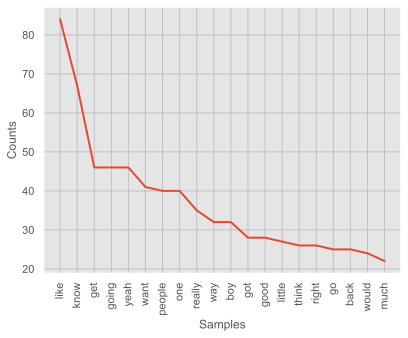

Most common words: [('like', 84), ('know', 67), ('get', 46), ('going', 46), ('yeah', 46), ('want', 41), ('people', 40), ('one', 40), ('really', 35), ('way', 32)]


In [13]:
# Plot frequency distribution and word cloud for clean transcripts
%matplotlib inline
print("Analysis of Transcripts:")
plot_freq_dist(clean_transcripts)
analyze_text(' '.join(clean_transcripts))

Analysis of Captions:
<FreqDist with 1953 samples and 2842 outcomes>


Most common words: [('reply', 59), ('one', 17), ('video', 15), ('day', 13), ('1', 12), ('know', 12), ('love', 11), ('de', 11), ('jij', 10), ('antwoorden', 10)]


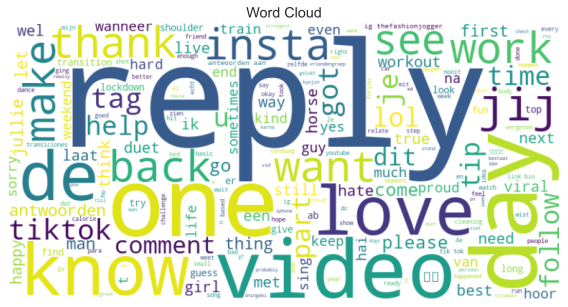

In [14]:
# Plot frequency distribution and word cloud for clean texts
print("Analysis of Captions:")
plot_freq_dist(clean_texts)
analyze_text(' '.join(clean_texts))

Analysis of Hashtags:
<FreqDist with 2220 samples and 5330 outcomes>


Most common words: [('fyp', 417), ('foryou', 272), ('foryoupage', 174), ('fy', 116), ('fitness', 87), ('workout', 73), ('voorjou', 72), ('viral', 65), ('animeedit', 63), ('anime', 50)]


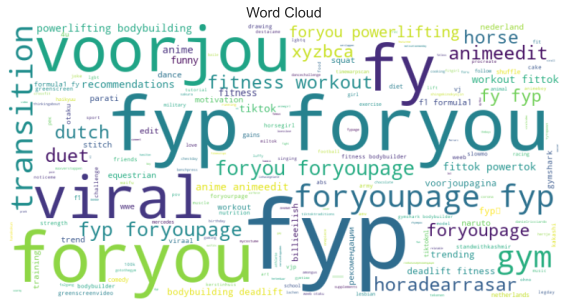

In [15]:
# Plot frequency distribution and word cloud for hashtags
print("Analysis of Hashtags:")
plot_freq_dist(hashtags)
analyze_text(' '.join(hashtags))

As we can see, it does not seem that a clear keyword is used in the transcripts or captions. Nevertheless, most tiktok videos has the hashtag ``fyp``, ``foryou``, ``foryoupage``, maybe in order to be recommended to users with similar interests. Furthermore, the most used ones are related with the exercise and anime.

Other techniques such as tf idf, post tagging, NER, topic modelling, etc. do not seem to have a clear usefulness for this use case. Likewise, an example is made to indicate its operation.

In [16]:
# Example usage with clean transcripts and clean texts
sentences = clean_transcripts + clean_texts
get_bag_of_words(sentences)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
{'let': 1664, 'place': 2176, 'getting': 1193, 'lot': 1730, 'people': 2144, 'asking': 241, 'recommending': 2383, 'use': 3074, 'sirens': 2613, 'security': 2529, 'guards': 1264, 'comments': 627, 'wanted': 3177, 'touch': 2976, 'also': 166, 'known': 1590, 'selective': 2539, 'androgenic': 189, 'receptor': 2378, 'modulators': 1897, 'held': 1329, 'next': 1989, 'generation': 1182, 'anabolic': 186, 'steroids': 2745, 'yielding': 3286, 'similar': 2604, 'results': 2431, 'without': 3245, 'side': 2599, 'effects': 908, 'true': 3019, 'starters': 2730, 'essentially': 968, 'completely': 640, 'unregulated': 3064, 'industry': 1445, 'according': 91, 'dr': 854, 'bill': 374, 'lewellen': 1672, 'likely': 1690, 'get': 1190, 'paid': 2104, 'said': 2487, 'chance': 546, 'rest': 2429, 'know': 1587, 'much': 1931, 'nobody': 2007, 'regardless': 2390, 'anybody': 207, 'might': 1858, 'tell': 2878, 'minima

In [17]:
# Example usage
topics_per_video = perform_topic_modeling(video_data)
for video_id, topics in topics_per_video.items():
    print("Topics for video", video_id)
    print(topics)

Topics for video 6907228749016714497
[(0, '1.000*"confidence went"'), (1, '1.000*"confidence went"')]
Topics for video 6875468410612993286
[(0, '1.000*"quiet zone follow insta joeysofo comment wan na see blade next reply"'), (1, '1.000*"quiet zone follow insta joeysofo comment wan na see blade next reply"')]
Topics for video 6898699405898059010
[(0, '0.143*"fyp" + 0.143*"iphone"'), (1, '0.143*"bend" + 0.143*"tiktok"')]
Topics for video 6902819837345533186
No cleaned data available
Topics for video 6905635666588192002
[(0, '0.500*"tiktok教室" + 0.500*"tutorial"'), (1, '0.500*"tutorial" + 0.500*"tiktok教室"')]
Topics for video 6895497835681287426
[(0, '0.250*"volleyball" + 0.250*"volleyballlove"'), (1, '0.250*"great rally show love comments" + 0.250*"volleyballworld"')]
Topics for video 6895303013867539713
[(0, '1.000*"oh"'), (1, '1.000*"oh"')]
Topics for video 6884590643327290625
[(0, '1.000*"timewarpscan"'), (1, '1.000*"timewarpscan"')]
Topics for video 6906514963569888513
[(0, '0.077*"erk

It is easily observable that no large conclusions can be drawn from these exploratory and feature extraction methods. This is due to the short and incomprehensible texts of the videos and transcripts without the rest of the information.

We already knew that text was our weakest source of information, and from which we could possibly extract the least information.

### Sentiment analysis

Now, the final step of data exploration and feature extraction focuses on a basic sentiment analysis. The goal is to extract more information from the videos in order to create more accurate models, or even to consider the possibility of using models that do not rely on text, but only on hashtags and sentiments to predict their virality. Both models will be tested to observe which ones obtain more accurate results for our training and validation sets, which will be divided in the next step.

In [18]:
classify_sentiment(video_data)

In [19]:
video_data

{'6907228749016714497': {'transcription': '',
  'text': 'Confidence went 📈',
  'hashtags': [],
  'clean_transcription': '',
  'clean_text': 'confidence went',
  'all_text': 'Transcription: No transcription. Caption: confidence went. Hashtags: No hashtags.',
  'clean_all_text': 'transcription transcription caption confidence went hashtags hashtags',
  'text_sentiment': 'Positive',
  'transcript_sentiment': 'Unknown'},
 '6875468410612993286': {'transcription': '',
  'text': 'Quiet Zone... follow me on insta: joeysofo. Comment where you wanna see me blade next. Reply to @dwight_schnuute',
  'hashtags': [],
  'clean_transcription': '',
  'clean_text': 'quiet zone follow insta joeysofo comment wan na see blade next reply',
  'all_text': 'Transcription: No transcription. Caption: quiet zone follow insta joeysofo comment wan na see blade next reply. Hashtags: No hashtags.',
  'clean_all_text': 'transcription transcription caption quiet zone follow insta joeysofo comment wan na see blade next 

In [20]:
# Count the sentiments of the videos
count_sentiments(video_data)

Sentiment Counts for Text and Transcriptions (BLOB):

Sentiment  Text       Transcription
Positive   139        109       
Negative   63         45        
Neutral    798        846       
Unknown    0          0         


Sentiment Counts for Text and Transcriptions (VADER):

Sentiment  Text       Transcription
Positive   152        132       
Negative   63         50        
Neutral    785        818       
Unknown    0          0         


Sentiment Counts for Text and Transcriptions (BOTH):

Sentiment  Text       Transcription
Positive   202        137       
Negative   88         60        
Neutral    672        64        
Unknown    38         739       




As can be seen, most videos are either unlabeled or neutral, especially when looking at the transcriptions, although there appear to be more videos classified as positive sentiment than negative. Additionally, the hybrid method seems to be more effective, using both TextBlob and VADER for sentiment analysis and producing a combined response.

Finally, it's normal for the sentiments of a video's transcription and caption to differ, as captions may consist solely of hashtags or may indicate a response, among other possibilities.

### Embedding creation

The next and last step before the model creation will be the train/test split, the addition of out virality response variable, created, explained and stored in the ``project.ipynb`` and the embedding creation.

In [21]:
csv_path = os.path.join(root_dir, csv_file)

df_virality = pd.read_csv(csv_path)

data = []

for video_id, info in video_data.items():
    virality_info = df_virality[df_virality['id'] == int(video_id)]
    if not virality_info.empty:
        combined_info = {
            'video_id': video_id,
            'hashtags': info['hashtags'],
            'all_text': info['all_text'],
            'clean_all_text': info['clean_all_text'],
            'norm_virality': virality_info['norm_virality'].values[0]  # Add norm_virality from the DataFrame
        }
        if info['transcription']:
            combined_info['clean_transcription'] = info['clean_transcription']
            combined_info['transcript_sentiment'] = info['transcript_sentiment']
        else:
            combined_info['clean_transcription'] = ''
            combined_info['transcript_sentiment'] = ''
        if info['text']:
            combined_info['clean_text'] = info['clean_text']
            combined_info['text_sentiment'] = info['text_sentiment']
        else:
            combined_info['clean_text'] = ''
            combined_info['text_sentiment'] = ''
        data.append(combined_info) if int(video_id) in df_virality['id'].values else print(f"Video {video_id} not in virality data")
        
df = pd.DataFrame(data)

df

video_id                                           hashtags  \
0    6907228749016714497                                                 []   
1    6875468410612993286                                                 []   
2    6898699405898059010           [tiktok, viral, fyp, iphone, test, bend]   
3    6902819837345533186                                                 []   
4    6905635666588192002                               [tiktok教室, tutorial]   
..                   ...                                                ...   
995  6877191692341054721                               [foryou, foryoupage]   
996  6908069845825359109  [gttfg, gotothegym, swolefam, nutrition, diet,...   
997  6883484287434378497                           [fy, foryoupage, foryou]   
998  6898721943978036481                               [fyp, foryou, curls]   
999  6899116261746281730  [horserider, horsegirl, equestrian, equestrian...   

                                              all_text  \
0    Transcription: No transcription. Caption: conf...   
1    Transcription: No transcription. Caption: quie...   
2    Transcription: No transcription. Caption: ipho...   
3    Transcription: No transcription. Caption: No t...   
4    Transcription: No transcription. Caption: No t...   
..                                                 ...   
995  Transcription: hi please scroll seen video mea...   
996  Transcription: fuck pumpkin spice stop shoveli...   
997  Transcription: No transcription. Caption: No t...   
998  Transcription: imagine long beautiful hair one...   
999  Transcription: No transcription. Caption: coll...   

                                        clean_all_text  norm_virality  \
0    transcription transcription caption confidence...       0.000177   
1    transcription transcription caption quiet zone...       0.003337   
2    transcription transcription caption iphone ben...       0.060929   
3    transcription transcription caption text hasht...       0.000377   
4    transcription transcription caption text hasht...       0.000457   
..                                                 ...            ...   
995  transcription hi please scroll seen video mean...       0.000513   
996  transcription fuck pumpkin spice stop shovelin...       0.000320   
997  transcription transcription caption text hasht...       0.001790   
998  transcription imagine long beautiful hair one ...       0.000286   
999  transcription transcription caption collab kno...       0.001232   

                                   clean_transcription transcript_sentiment  \
0                                                                             
1                                                                             
2                                                                             
3                                                                             
4                                                                             
..                                                 ...                  ...   
995  hi please scroll seen video means small creato...             Negative   
996  fuck pumpkin spice stop shoveling garbage mout...             Negative   
997                                                                           
998  imagine long beautiful hair one day wake think...             Positive   
999                                                                           

                                            clean_text text_sentiment  
0                                      confidence went       Positive  
1    quiet zone follow insta joeysofo comment wan n...       Negative  
2                                          iphone bend        Neutral  
3                                                                      
4                                                             Neutral  
..                                                 ...            ...  
995                                     

Prior to the model creation, an embedding model is used to transform the clean text, transcript and hashtags. It could also be investigated with different embedding models, but it is not the objective of this work, so a HuggingFace model with good general results is chosen.

In [22]:
# # First execution may be long due to the model download

# model = INSTRUCTOR('hkunlp/instructor-xl')
# device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [23]:
# # Text embedding creation 
# embeddings = model.encode(sentences=df['clean_text'].values, show_progress_bar=True, device=device, normalize_embeddings=True)

In [24]:
# # Text embedding storage
# df['text_embedding'] = embeddings.tolist()

In [25]:
# # Transcription embedding creation & storage
# embeddings = model.encode(sentences=df['clean_transcription'].values, show_progress_bar=True, device=device, normalize_embeddings=True)
# df['transcription_embedding'] = embeddings.tolist()

In [26]:
# # Cleaned All Text embedding creation & storage
# embeddings = model.encode(sentences=df['clean_all_text'].values, show_progress_bar=True, device=device, normalize_embeddings=True)
# df['clean_all_text'] = embeddings.tolist()

In [27]:
# df

In [28]:
# df.to_csv(os.path.join(root_dir, textcsv_file, 'embeddings.csv'), index=False)

In [89]:
df = pd.read_csv(os.path.join(root_dir, textcsv_file, 'embeddings.csv'))
df['hashtags'] = df['hashtags'].apply(ast.literal_eval)

In [90]:
# Tokenize hashtags into lists of words
tokenized_hashtags = [hashtag.split() for hashtag in hashtags]

In [91]:
# Find the maximum number of hashtags in any video
max_hashtags = max(df['hashtags'].apply(len))

# Create new columns for each hashtag
for i in range(1, max_hashtags + 1):
    df[f'hashtag_{i}'] = ''

# Populate the new columns with hashtags
for index, hashtags in enumerate(df['hashtags']):
    for i, hashtag in enumerate(hashtags):
        if i < max_hashtags:
            df.at[index, f'hashtag_{i+1}'] = hashtag

In [92]:
for feature in ['transcription_embedding', 'text_embedding', 'clean_all_text']:
    df[feature] = df[feature].apply(ast.literal_eval)

In [93]:
for i in range(1, max_hashtags + 1):
    df[f'hashtag_{i}'] = df[f'hashtag_{i}'].astype(str)

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   video_id                 1000 non-null   int64  
 1   hashtags                 1000 non-null   object 
 2   all_text                 1000 non-null   object 
 3   clean_all_text           1000 non-null   object 
 4   norm_virality            1000 non-null   float64
 5   clean_transcription      256 non-null    object 
 6   transcript_sentiment     261 non-null    object 
 7   clean_text               757 non-null    object 
 8   text_sentiment           962 non-null    object 
 9   text_embedding           1000 non-null   object 
 10  transcription_embedding  1000 non-null   object 
 11  hashtag_1                1000 non-null   object 
 12  hashtag_2                1000 non-null   object 
 13  hashtag_3                1000 non-null   object 
 14  hashtag_4                

In [95]:
df2 = df.copy()

In [96]:
# Train Word2Vec model for hashtags
hashtag_model = Word2Vec(sentences=tokenized_hashtags, vector_size=50, window=5, min_count=1, workers=8, seed=42)

# Apply the function to create embeddings for each row in the DataFrame
for i in range(1, max_hashtags + 1):
    df2[f"hashtag_embedding_{i}"] = df2[f"hashtag_{i}"].apply(lambda hashtag: hashtag_model.wv[hashtag] if hashtag in hashtag_model.wv else np.zeros(50))

In [97]:
df_clean = df2.drop(columns=['hashtags', 'clean_transcription', 'clean_text', 'transcript_sentiment', 'text_sentiment'])

for i in range(1, max_hashtags + 1):
    df_clean = df_clean.drop(columns=[f'hashtag_{i}'])

In [98]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   video_id                 1000 non-null   int64  
 1   all_text                 1000 non-null   object 
 2   clean_all_text           1000 non-null   object 
 3   norm_virality            1000 non-null   float64
 4   text_embedding           1000 non-null   object 
 5   transcription_embedding  1000 non-null   object 
 6   hashtag_embedding_1      1000 non-null   object 
 7   hashtag_embedding_2      1000 non-null   object 
 8   hashtag_embedding_3      1000 non-null   object 
 9   hashtag_embedding_4      1000 non-null   object 
 10  hashtag_embedding_5      1000 non-null   object 
 11  hashtag_embedding_6      1000 non-null   object 
 12  hashtag_embedding_7      1000 non-null   object 
 13  hashtag_embedding_8      1000 non-null   object 
 14  hashtag_embedding_9      

### Train/Test split

It will be used **$80\%$** of the data for training, **$10\%$** for validation and **$10\%$** for testing the correctness and lack of overfitting of the final model.

In [99]:
train_df, Test_df = train_test_split(df_clean, test_size=0.2, random_state=42)

validation_df, test_df = train_test_split(Test_df, test_size=0.5, random_state=42)

In [100]:
test_df

video_id                                           all_text  \
436  6898628429298568450  Transcription: No transcription. Caption: No t...   
899  6903974884154608897  Transcription: No transcription. Caption: uuuu...   
346  6894047232274812165  Transcription: No transcription. Caption: okay...   
60   6896962911969758466  Transcription: ok google. Caption: hard work. ...   
867  6886298413885918465  Transcription: No transcription. Caption: No t...   
..                   ...                                                ...   
213  6900185373540961537  Transcription: No transcription. Caption: naas...   
884  6885791166248340737  Transcription: seems tik tok lot people believ...   
626  6895317957522541825  Transcription: No transcription. Caption: emba...   
986  6902823504383659266  Transcription: No transcription. Caption: vand...   
892  6887458979954347266  Transcription: No transcription. Caption: жизн...   

                                        clean_all_text  norm_virality  \
436  [0.023778149858117104, 0.004564602859318256, 0...       0.000268   
899  [0.024861475452780724, -0.011723614297807217, ...       0.000127   
346  [0.018007317557930946, 0.03486478701233864, 0....       0.000302   
60   [0.015249306336045265, -0.0059671481139957905,...       0.000176   
867  [0.03756435588002205, 0.02244965359568596, 0.0...       0.000177   
..                                                 ...            ...   
213  [0.023535972461104393, -0.00017364155792165548...       0.000122   
884  [0.06692484766244888, -0.0170977134257555, 0.0...       0.000132   
626  [0.04969573765993118, 0.009726935997605324, -0...       0.001672   
986  [0.04537423327565193, 0.011458877474069595, 0....       0.000323   
892  [0.05391174554824829, 0.019364837557077408, -0...       0.000693   

                                        text_embedding  \
436  [0.04192333295941353, -0.007496909704059362, -...   
899  [-0.01943052001297474, -0.028604578226804733, ...   
346  [-0.007570543326437473, 0.001123668160289526, ...   
60   [0.03188280761241913, 0.00465205917134881, -0....   
867  [0.04192333295941353, -0.007496909704059362, -...   
..                                                 ...   
213  [0.010551031678915024, 0.0029549868777394295, ...   
884  [0.018415972590446472, -0.050034280866384506, ...   
626  [0.03151969239115715, 0.00880822166800499, -0....   
986  [0.013059204444289207, -0.005901109892874956, ...   
892  [0.032076966017484665, 0.02020498737692833, 0....   

                               transcription_embedding  \
436  [0.04192333295941353, -0.007496909704059362, -...   
899  [0.04192333295941353, -0.007496909704059362, -...   
346  [0.04192333295941353, -0.007496909704059362, -...   
60   [0.024793338030576706, 0.022074377164244652, 0...   
867  [0.04192333295941353, -0.007496909704059362, -...   
..                                                 ...   
213  [0.04192333295941353, -0.007496909704059362, -...   
884  [0.0614435113966465, -0.024465279653668404, -0...   
626  [0.04192333295941353, -0.007496909704059362, -...   
986  [0.04192333295941353, -0.007496909704059362, -...   
892  [0.041923366487026215, -0.007496913895010948, ...   

                                   hashtag_embedding_1  \
436  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
899  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
346  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
60   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
867  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
..                                                 ...   
213  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
884  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
626  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
986  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
892  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                   hashtag_embedding_2  \
436  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

## Text Model Creation

Before continuing with the creation of the models, it is necessary to explain the problem that concerns us. 

Unlike traditional text NLP models, for each observation we have more than one variable with associated text. Therefore, 3 different techniques are available:

 + Embedding transformation of each variable and use them separately.

 + Mixing all embeddings generated by caption, transcription and hashtags.

 + Creation of traditional models using the extracted characteristics (text sentiment, transcription sentiment and hashtags) as qualitative variables.

The first and second cases are more related to text analysis, so they will be the most developed.

### First approach

Due to the fact that every variable is a vector, we cannot use a model whose variables are vectors. Therefore, we are going to concatenate all embeddings into a single vector. It could also be deployed a model for each variable and a fourth model (a MLP, for instance) to learn how to mix them properly and apply correct weights in order to minimize the loss, but it is a method that needs more resources than the current ones, so it is not going to be tested.

In [101]:
# Defining features and target variables
features = [col for col in train_df.columns.tolist() if col not in ['video_id', 'norm_virality', 'hashtag_embeddings', 'all_text', 'clean_all_text']]
target = "norm_virality"

# Training set
x_Train = train_df[features]
y_train = train_df[target]

# Validation set
x_Valid = validation_df[features]
y_valid = validation_df[target]

# Test set
x_Test = test_df[features]
y_test = test_df[target]

#### ML models

In [102]:
x_Train

text_embedding  \
29   [0.04192333295941353, -0.007496909704059362, -...   
535  [0.003779997117817402, 0.026950815692543983, 0...   
695  [0.04192333295941353, -0.007496909704059362, -...   
557  [0.04192333295941353, -0.007496909704059362, -...   
836  [-0.04106039181351662, -0.03510419651865959, 0...   
..                                                 ...   
106  [0.053517188876867294, 0.007590239401906729, -...   
270  [-0.015197990462183952, -0.007860840298235416,...   
860  [0.005934877786785364, 0.0070270211435854435, ...   
435  [0.008213895373046398, 0.018008287996053696, 0...   
102  [0.03924030438065529, 0.012630526907742023, -0...   

                               transcription_embedding  \
29   [0.04192333295941353, -0.007496909704059362, -...   
535  [0.04192333295941353, -0.007496909704059362, -...   
695  [0.024513650685548782, 0.019777517765760422, 0...   
557  [0.04192333295941353, -0.007496909704059362, -...   
836  [0.04192333295941353, -0.007496909704059362, -...   
..                                                 ...   
106  [-0.03723090514540672, 0.057634979486465454, 0...   
270  [0.04192333295941353, -0.007496909704059362, -...   
860  [0.04192333295941353, -0.007496909704059362, -...   
435  [0.04192333295941353, -0.007496909704059362, -...   
102  [0.04192333295941353, -0.007496909704059362, -...   

                                   hashtag_embedding_1  \
29   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
535  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
695  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
557  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
836  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
..                                                 ...   
106  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
270  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
860  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
435  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
102  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                   hashtag_embedding_2  \
29   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
535  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
695  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
557  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
836  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
..                                                 ...   
106  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
270  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
860  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
435  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
102  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                   hashtag_embedding_3  \
29   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
535  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
695  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
557  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
836  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
..                                                 ...   
106  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
270  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
860  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
435  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
102  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                   hashtag_embedding_4  \
29   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
535  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
695  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
557  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
836  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
..                                                 ...   
106  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
270  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
860  [0.0, 0.0, 0.0, 0.0, 0.0, 0.

In [103]:
# Iterate over each DataFrame
for name, df_aux in zip(['x_train', 'x_valid', 'x_test'], [x_Train, x_Valid, x_Test]):
    # Concatenate the embeddings
    df_concatenated = df_aux.apply(concatenate_embeddings, axis=1, df=df_aux)
    
    # Create a DataFrame from the concatenated vectors
    df_concatenated = pd.DataFrame(df_concatenated.tolist(), columns=[f'embedding_{i}' for i in range(len(df_concatenated.iloc[0]))])
    
    # Assign the new DataFrame to the respective variable
    exec(f"{name} = df_concatenated")

In [43]:
y_valid

411    0.001354
621    0.000856
721    0.000165
914    0.000198
917    0.000172
         ...   
554    0.000322
938    0.002726
522    0.000406
677    0.000733
936    0.018364
Name: norm_virality, Length: 100, dtype: float64

In [44]:
# Now the dfs contain each element of the concatenated vector as a separate column
x_train = x_train.astype(float)
x_valid = x_valid.astype(float)
x_test = x_test.astype(float)

## Create dataset to store model predictions
dfTR_eval = x_train.copy()
# Reset the index of y_train
y_train = y_train.reset_index(drop=True)
dfTR_eval['virality'] = y_train
dfV_eval = x_valid.copy()
# Reset the index of y_valid
y_valid = y_valid.reset_index(drop=True)
dfV_eval['virality'] = y_valid
dfTS_eval = x_test.copy()
# Reset the index of y_test
y_test = y_test.reset_index(drop=True)
dfTS_eval['virality'] = y_test

x_train

embedding_0  embedding_1  embedding_2  embedding_3  embedding_4  \
0       0.041923    -0.007497    -0.004069    -0.082524    -0.063610   
1       0.003780     0.026951     0.026920    -0.046266    -0.021588   
2       0.041923    -0.007497    -0.004069    -0.082524    -0.063610   
3       0.041923    -0.007497    -0.004069    -0.082524    -0.063610   
4      -0.041060    -0.035104     0.014881    -0.049118    -0.085768   
..           ...          ...          ...          ...          ...   
795     0.053517     0.007590    -0.020349    -0.050283    -0.029132   
796    -0.015198    -0.007861     0.006591    -0.008356    -0.037911   
797     0.005935     0.007027    -0.014449    -0.034437    -0.000372   
798     0.008214     0.018008     0.011643    -0.079032    -0.058736   
799     0.039240     0.012631    -0.008034    -0.054017    -0.044314   

     embedding_5  embedding_6  embedding_7  embedding_8  embedding_9  ...  \
0      -0.022734    -0.074771    -0.013336    -0.004132    -0.018243  ...   
1      -0.051692    -0.095551     0.002809     0.007682    -0.041052  ...   
2      -0.022734    -0.074771    -0.013336    -0.004132    -0.018243  ...   
3      -0.022734    -0.074771    -0.013336    -0.004132    -0.018243  ...   
4      -0.017055    -0.053470    -0.010991    -0.012701    -0.043292  ...   
..           ...          ...          ...          ...          ...  ...   
795    -0.031704    -0.065116     0.002502     0.009686     0.001515  ...   
796    -0.031175    -0.076944     0.014347     0.017649    -0.034928  ...   
797    -0.016070    -0.107569    -0.019914     0.022525    -0.034131  ...   
798    -0.001476    -0.087954     0.001236     0.012271     0.013919  ...   
799    -0.043912    -0.045707    -0.013930    -0.007821    -0.036483  ...   

     embedding_2426  embedding_2427  embedding_2428  embedding_2429  \
0               0.0             0.0             0.0             0.0   
1               0.0             0.0             0.0             0.0   
2               0.0             0.0             0.0             0.0   
3               0.0             0.0             0.0             0.0   
4               0.0             0.0             0.0             0.0   
..              ...             ...             ...             ...   
795             0.0             0.0             0.0             0.0   
796             0.0             0.0             0.0             0.0   
797             0.0             0.0             0.0             0.0   
798             0.0             0.0             0.0             0.0   
799             0.0             0.0             0.0             0.0   

     embedding_2430  embedding_2431  embedding_2432  embedding_2433  \
0               0.0             0.0             0.0             0.0   
1               0.0             0.0             0.0             0.0   
2               0.0             0.0             0.0             0.0   
3               0.0             0.0             0.0             0.0   
4               0.0             0.0             0.0             0.0   
..              ...             ...             ...             ...   
795             0.0             0.0             0.0             0.0   
796             0.0             0.0             0.0             0.0   
797             0.0             0.0             0.0             0.0   
798             0.0             0.0             0.0             0.0   
799             0.0             0.0             0.0             0.0   

     embedding_2434  embedding_2435  
0               0.0             0.0  
1               0.0             0.0  
2               0.0             0.0  
3               0.0             0.0  
4               0.0             0.0  
..              ...             ...  
795             0.0             0.0  
796             0.0             0.0  
797             0.0             0.0  
798             0.0             0.0  
799             0.0             0.0  

[800 rows x 2436 columns]

**Linear Regression**

In [45]:
# Define your input columns
INPUTS_LR_NUM = x_train.columns.tolist()
INPUTS_LR_CAT = []
INPUTS_LR = INPUTS_LR_NUM + INPUTS_LR_CAT

# Define your preprocessing steps
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))])

# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, INPUTS_LR_NUM),
    ('cat', categorical_transformer, INPUTS_LR_CAT)
])

# Create your pipeline
pipe = Pipeline(steps=[('Prep', preprocessor),
                       ('LinReg', LinearRegression())])

# Define the parameters for grid search
param = {}

# Perform grid search cross-validation
nFolds = 10
LR_fit = GridSearchCV(estimator=pipe,
                      param_grid=param,
                      n_jobs=-1,
                      cv=nFolds)
LR_fit.fit(x_train[INPUTS_LR], y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('Prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['embedding_0',
                                                                          'embedding_1',
                                                                          'embedding_2',
                                                                          'embedding_3',
                                                                          'embedding_4',
                                                                          'embedding_5',
                                                                          'embedding_6',
                                                                          'embedding_7',
                                                                          'embedding_8',
                                                                          'embedding_9',
                                                                          'embedding_10',
                                                                          'embedding_11',
                                                                          'embedding_12',
                                                                          'embedding_13',
                                                                          'embedding_...
                                                                          'embedding_17',
                                                                          'embedding_18',
                                                                          'embedding_19',
                                                                          'embedding_20',
                                                                          'embedding_21',
                                                                          'embedding_22',
                                                                          'embedding_23',
                                                                          'embedding_24',
                                                                          'embedding_25',
                                                                          'embedding_26',
                                                                          'embedding_27',
                                                                          'embedding_28',
                                                                          'embedding_29', ...]),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         [])])),
                                       ('LinReg', LinearRegression())]),
             n_jobs=-1, param_grid={})

In [46]:
# Predictions
dfTR_eval['LR_pred'] = LR_fit.predict(x_train)
dfV_eval['LR_pred'] = LR_fit.predict(x_valid)

In [47]:
# Calculate metrics for training set
train_rmse, train_mse, train_mae = calculate_metrics(y_train, dfTR_eval['LR_pred'])

# Calculate metrics for validation set
valid_rmse, valid_mse, valid_mae = calculate_metrics(y_valid, dfV_eval['LR_pred'])

In [48]:
print("Training Metrics:")
print("RMSE:", train_rmse)
print("MSE:", train_mse)
print("MAE:", train_mae)

print("\nValidation Metrics:")
print("RMSE:", valid_rmse)
print("MSE:", valid_mse)
print("MAE:", valid_mae)

Training Metrics:
RMSE: 0.0010134889611592513
MSE: 1.027159874391658e-06
MAE: 9.678748852049479e-05

Validation Metrics:
RMSE: 791095605.6506995
MSE: 6.25832257279847e+17
MAE: 582490351.7321801


Clearly, methods like linear regression does not seem to be effective in these type of problems. Nonetheless, we are going to try with one better ML model: random forests.

**Random Forest**

In [49]:
# find optim nº of trees in the ensemble and max_features
param = {'RF__min_impurity_decrease': np.arange(0,0.0001,0.00001),
        'RF__n_estimators': range(30, 150, 10)} # Number of trees in the forest # range(20, 1000, 100), ...

# Tested
# 'RF__min_samples_split': range(2, 30, 5)
# 'RF__min_samples_leaf': range(2, 30, 5)
# 'RF__min_impurity_decrease': np.arange(0.00001,0.0001,0.0001), np.arange(0.002,0.01,0.001), ...
         
pipe =  Pipeline(steps=[('RF', 
                            RandomForestRegressor(
                                        max_features='sqrt', 
                                        min_samples_split = 2,
                                        min_samples_leaf = 1,
                                        random_state=42)
                        )])

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
rf_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='neg_mean_squared_error', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 

# fit the bagged trees
INPUTS_BT = INPUTS_LR                 
rf_fit.fit(x_train[INPUTS_BT], y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('RF',
                                        RandomForestRegressor(max_features='sqrt',
                                                              random_state=42))]),
             n_jobs=-1,
             param_grid={'RF__min_impurity_decrease': array([0.e+00, 1.e-05, 2.e-05, 3.e-05, 4.e-05, 5.e-05, 6.e-05, 7.e-05,
       8.e-05, 9.e-05]),
                         'RF__n_estimators': range(30, 150, 10)},
             scoring='neg_mean_squared_error')

In [50]:
rf_fit.best_params_

{'RF__min_impurity_decrease': 8e-05, 'RF__n_estimators': 40}

In [51]:
MT.plotModelGridError(rf_fit)

In [52]:
# Predictions
dfTR_eval['RF_pred'] = rf_fit.predict(x_train)
dfV_eval['RF_pred'] = rf_fit.predict(x_valid)

In [53]:
# Calculate metrics for training set
train_rmse, train_mse, train_mae = calculate_metrics(y_train, dfTR_eval['RF_pred'])

# Calculate metrics for validation set
valid_rmse, valid_mse, valid_mae = calculate_metrics(y_valid, dfV_eval['RF_pred'])

In [54]:
print("Training Metrics:")
print("RMSE:", train_rmse)
print("MSE:", train_mse)
print("MAE:", train_mae)

print("\nValidation Metrics:")
print("RMSE:", valid_rmse)
print("MSE:", valid_mse)
print("MAE:", valid_mae)

Training Metrics:
RMSE: 0.017167622728263124
MSE: 0.0002947272701399766
MAE: 0.004896696853927099

Validation Metrics:
RMSE: 0.010520194252257064
MSE: 0.00011067448710522256
MAE: 0.004130197508232826


As we can see, models that uses CV and hyperparameter optimization are much better, improving its ability to predict and generalize. Specially, random forests is one of the best methods for ML prediction, so its good results are not something to be surprised. It is important to bear in mind that our response variable moves between 0-1, so a RMSE of 0.0178577 it is equivalent to a RMSE near 1.8 in a vector with a maximum of 100 (but most of them below 10, so the results are not as good as it seems).

After this basic methods, some simple neural networks are tested. It will be used a DenseNet, a RNN and a LSTM/GRU, before entering deeper neural networks and pretrained models.

#### Deep learning custom models

In [55]:
# Convert Pandas DataFrames to NumPy arrays
x_train_array = x_train.values
y_train_array = y_train.values

x_valid_array = x_valid.values
y_valid_array = y_valid.values

**DENSENET**

In [56]:
# Define the model architecture
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(2436,)))  # Assuming each row represents a sentence embedding
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='linear')) # Linear activation for regression

c:\Users\juanl\Documents\Master\2o cuatri\ADNE\Trabajo\Tik Tok\tiktok\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [57]:
# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss=losses.mean_squared_error)  # Using mean squared error loss for regression

In [58]:
# Train the model
history = model.fit(x_train_array,
                    y_train_array,  
                    epochs=50, batch_size=16, 
                    validation_data=(x_valid_array, y_valid_array))

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.3249e-04 - mean_squared_error: 5.3249e-04 - val_loss: 1.9056e-04 - val_mean_squared_error: 1.9056e-04
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3700e-04 - mean_squared_error: 4.3700e-04 - val_loss: 1.6711e-04 - val_mean_squared_error: 1.6711e-04
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1548e-04 - mean_squared_error: 4.1548e-04 - val_loss: 1.6657e-04 - val_mean_squared_error: 1.6657e-04
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7283e-04 - mean_squared_error: 6.7283e-04 - val_loss: 1.6430e-04 - val_mean_squared_error: 1.6430e-04
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8981e-04 - mean_squared_error: 1.8981e-04 - val_loss: 1.7066e-04 - val_mean_squared_error: 1.7066e-04
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8858e-04 - mean_squared_error: 2.8858e-04 - val_loss: 1.9779e-04 - val_mean_squared_error: 1.9779e-04
Epoch 7/50
50/50 ━━━━━━━━━━━

In [59]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])

In [60]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [62]:
# Evaluate the model on test data
valid_loss, valid_mse = model.evaluate(x_valid_array, y_valid_array)

print("Test Loss:", valid_loss)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1642e-04 - mean_squared_error: 3.1642e-04 
Test Loss: 0.0002480775292497128
Test Mean Squared Error: 0.0002480775292497128


From these results two conclusions can be drawn:

 + The first one is that this simple densenet model has a slightly higher test MSE than Random Forest, so it may indicate that there is not enough information in the text to require a complex model.

 + On the other hand, the test error seems to remain constant, something that is not recommended since, therefore, the model adjusts only to the training data with clear symptoms of overfitting. This could also be for several reasons:

    + It is needed a more complex neural network (it is going to be tested afterwards).

    + There is not so much information in the text and it is not possible to be more precise without more information (audio and video), having a MSE barrier that it is not possible for us to surpass.

    + There is something wrong with the model of data.



The main reason seems to be the second one of the second statement, but the study will keep on with a RNN and a LSTM.

**RNN**

In [63]:
model = models.Sequential()
model.add(layers.SimpleRNN(128, input_shape=(None, 2436), return_sequences=True))
model.add(layers.SimpleRNN(64, return_sequences=True))
model.add(layers.SimpleRNN(32))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

c:\Users\juanl\Documents\Master\2o cuatri\ADNE\Trabajo\Tik Tok\tiktok\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, None, 128)      │       328,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, None, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 343,809 (1.31 MB)

 Trainable params: 343,809 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:
# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss=losses.mean_squared_error)  # Using mean squared error loss for regression

In [65]:
# Expandir la dimensión de la entrada
x_train_rnn = np.expand_dims(x_train, axis=1)
x_valid_rnn = np.expand_dims(x_valid, axis=1)

In [66]:
# Train the model
history = model.fit(x_train_rnn,
                    y_train,  
                    epochs=100, batch_size=16, 
                    validation_data=(x_valid_rnn, y_valid))

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0961 - mean_squared_error: 0.0961 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 9.2510e-04 - val_mean_squared_error: 9.2510e-04
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 6.3027e-04 - val_mean_squared_error: 6.3027e-04
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 4.7345e-04 - val_mean_squared_error: 4.7345e-04
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.8096e-04 - mean_squared_error: 8.8096e-04 - val_loss: 3.7702e-04 - val_mean_squared_error: 3.7702e-04
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.2026e-04 - mean_s

In [67]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])

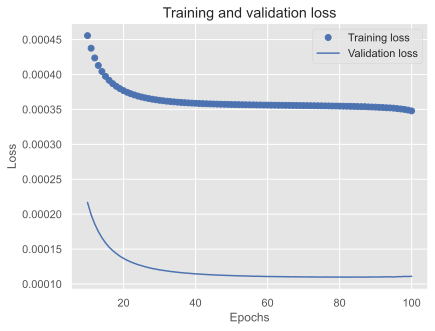

In [68]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(10, len(loss) + 1) # It starts on 10 to see in more detail the majority of epochs

# "bo" is for "blue dot"
plt.plot(epochs, loss[epochs[0]-1:], 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss[epochs[0]-1:], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [70]:
# Evaluate the model on test data
valid_loss = model.evaluate(x_valid_rnn, y_valid)

print("Test Loss:", valid_loss)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5963e-04 - mean_squared_error: 1.5963e-04 
Test Loss: 0.00011105578596470878
Test Mean Squared Error: 0.00011105578596470878


As it could be easily seen, this model is much better than the previous one. It does not have any sign of overfitting, with near the same values for training and testing. Furthermore, the test MSE is much lower, near the Random Forest one, but the ensemble method tended to overfit, so it seems to be the best model (even tough the improvement has been slight). 

**LSTM**

In [71]:
model = models.Sequential()
model.add(layers.LSTM(128, input_shape=(None, 2436), return_sequences=True))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

c:\Users\juanl\Documents\Master\2o cuatri\ADNE\Trabajo\Tik Tok\tiktok\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, None, 128)      │     1,313,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, None, 64)       │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,375,137 (5.25 MB)

 Trainable params: 1,375,137 (5.25 MB)

 Non-trainable params: 0 (0.00 B)

In [72]:
# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss=losses.mean_squared_error)  # Using mean squared error loss for regression

In [73]:
# Train the model
history = model.fit(x_train_rnn,
                    y_train,  
                    epochs=100, batch_size=16, 
                    validation_data=(x_valid_rnn, y_valid))

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.2437 - mean_squared_error: 0.2437 - val_loss: 0.2267 - val_mean_squared_error: 0.2267
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2112 - mean_squared_error: 0.2112 - val_loss: 0.1346 - val_mean_squared_error: 0.1346
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0984 - mean_squared_error: 0.0984 - val_loss: 0.0236 - val_mean_squared_error: 0.0236
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0168 - mean_squared_error: 0.0168 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0014 - v

In [74]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])

In [75]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(10, len(acc) + 1) # It starts on 10 to see in more detail the majority of epochs

# "bo" is for "blue dot"
plt.plot(epochs, loss[epochs[0]-1:], 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss[epochs[0]-1:], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [77]:
# Evaluate the model on test data
valid_loss, valid_mse = model.evaluate(x_valid_rnn, y_valid)

print("Test Loss:", valid_loss)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6011e-04 - mean_squared_error: 1.6011e-04 
Test Loss: 0.00011135826935060322
Test Mean Squared Error: 0.00011135826935060322


After testing a multitude of models with more and fewer layers, reaching models with almost 2 million parameters and both LSTM and GRU layers, no better results are obtained than those already obtained.

Clearly, better results cannot be obtained with models created from scratch, in addition to the lack of data that means we cannot train it more deeply. For that reason, the next and final step is based on the use of a pre-trained model, preferably a transformer (since they are achieving better results lately) to which, if necessary, the last layer will be changed and even fine tuning of the last layers will be performed.

#### Deep learning pre-trained models

After investigating the main pre-trained models, looking for those that focus on texts regression or classification by extracting their main characteristics (similar to our use case), especially for social networks, the most used are the BERT family. Among these, the most powerful and the one with the most models from other users having applied fine-tuning for social networks is RoBERTa, which is why this model is chosen. Specifically, the multilingual version of RoBERTa will be used (xlm-RoBERTa), due to the different ​​possible languages in the videos.

Here it is encountered a problem due to the architecture of pre-trained networks. Most come with built-in embedding creation to make the task easier, something that is not useful for us since we have concatenated all the embedding vectors. Therefore, the network architecture it is changed to the necessary liking.

In [78]:
# Load pre-trained model and tokenizer
model = AutoModelForMaskedLM.from_pretrained("xlm-roberta-base")

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [79]:
# Define the configuration for the XLM-RoBERTa model
config = XLMRobertaConfig.from_pretrained("xlm-roberta-base")
input_dim = x_train.shape[1]

In [80]:
# Modify the embedding layer to accept the desired input dimension and eliminate embedding creation (already done)
model.base_model.embeddings = nn.Linear(input_dim, config.hidden_size)

In [81]:
# Select only the encoder/decoder layer and modify the output layer for regression
model.config.num_labels = 1  # Change the number of output labels to 1 for regression
model.regressor = nn.Linear(model.config.hidden_size, 1)  # Replace the classifier with a regression layer

In [82]:
model

XLMRobertaForMaskedLM(
  (roberta): XLMRobertaModel(
    (embeddings): Linear(in_features=2436, out_features=768, bias=True)
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (intermediate): XLMRobertaIntermediate(
            (dense): Linear(in_features=768, out_features=30

In [84]:
print("Number of parameters for each layer:")
for name, param in model.named_parameters():
    print(f"{name}: {param.numel()}")

print("\nTotal number of trainable parameters:", count_parameters(model))

Number of parameters for each layer:
roberta.embeddings.weight: 1870848
roberta.embeddings.bias: 768
roberta.encoder.layer.0.attention.self.query.weight: 589824
roberta.encoder.layer.0.attention.self.query.bias: 768
roberta.encoder.layer.0.attention.self.key.weight: 589824
roberta.encoder.layer.0.attention.self.key.bias: 768
roberta.encoder.layer.0.attention.self.value.weight: 589824
roberta.encoder.layer.0.attention.self.value.bias: 768
roberta.encoder.layer.0.attention.output.dense.weight: 589824
roberta.encoder.layer.0.attention.output.dense.bias: 768
roberta.encoder.layer.0.attention.output.LayerNorm.weight: 768
roberta.encoder.layer.0.attention.output.LayerNorm.bias: 768
roberta.encoder.layer.0.intermediate.dense.weight: 2359296
roberta.encoder.layer.0.intermediate.dense.bias: 3072
roberta.encoder.layer.0.output.dense.weight: 2359296
roberta.encoder.layer.0.output.dense.bias: 768
roberta.encoder.layer.0.output.LayerNorm.weight: 768
roberta.encoder.layer.0.output.LayerNorm.bias: 76

In [85]:
num_layers_to_unfreeze = 0  # For example, unfreeze the top 3 layers
last_layer_unfreeze = False  # Unfreeze the last layer

# Freeze all parameters initially
for param in model.parameters():
    param.requires_grad = False
    
# Ensure that the first and last layer is trainable (added ones)
for param in model.base_model.embeddings.parameters():
    param.requires_grad = True
    
for param in model.regressor.parameters():
    param.requires_grad = True 

# Unfreeze the top layers
for name, param in model.named_parameters():
    if 'encoder.layer' in name:
        layer_num = int(name.split('.')[3])
        if layer_num >= (12 - num_layers_to_unfreeze):  # Only unfreeze specified number of layers
            param.requires_grad = True
            
    if 'lm_head' in name:
        if last_layer_unfreeze:
            param.requires_grad = True
        
        
# Ensure that the first and last layer is trainable (added ones)
for param in model.base_model.embeddings.parameters():
    param.requires_grad = True
    
for param in model.regressor.parameters():
    param.requires_grad = True 
            
# Count the number of trainable parameters
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters after unfreezing layers:", total_trainable_params)  


# With 1 layer unfrozen, there are more than 7M trainable parameters
# It has been tested that the number of paramters of the last layer is the same

Number of trainable parameters after unfreezing layers: 1872385


In [86]:
# Assuming x_train_array, x_valid_array, y_train, y_valid are your data arrays
train_dataset = CustomDataset(x_train_array, y_train)
val_dataset = CustomDataset(x_valid_array, y_valid)

# DataLoader
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

TypeError: CustomDataset.__init__() missing 1 required positional argument: 'tokenizer'

The error is given due to the change in the ``CustomDataset`` class for the second approach. If it was well defined, the error will be in the next cell, as explained afterwrads.

In [87]:
# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

num_epochs = 2

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_losses = []  # Store losses for this epoch
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))  # Unsqueeze labels to match output shape
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())  # Store loss value for this batch

    # Calculate mean training loss and MSE for this epoch
    mean_train_loss = np.mean(train_losses)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {mean_train_loss:.4f}")

    # Validation loop
    model.eval()
    val_losses = []  # Store losses for this epoch
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))  # Calculate loss
            val_losses.append(loss.item())  # Store loss value

    # Calculate mean validation loss and MSE for this epoch
    mean_val_loss = np.mean(val_losses)
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {mean_val_loss:.4f}")

# Save or use the trained model for inference
torch.save(model.state_dict(), 'regression_model.pth')

NameError: name 'train_dataloader' is not defined

With this code, the dataset and the network have already been transformed to meet the needs of the problem, but due to the implementation of the embedding layer, an error occurs due to necessary inputs. Here, the library can be lightly modified to make it work or a new network can be created using only the layers needed for this case. However, for both cases, it can be observed that without fine-tuning, there are already more than 1 million parameters to train, so pre-trained models will be used in the second approach, as it will be more convenient to use.

### Second approach

As already mentioned, in this second method a mix of all the information will be used in a single embedding, something much more compact and computationally less expensive. To do this, given that the length of the hashtag vectors is different and adding embeddings to each other does not make sense behind them, the clean_all_text column has been created, with a phrase that encapsulates all the text of a video previously transformed into embedding.

In [128]:
# Defining features and target variables
features = ['clean_all_text']
target = "norm_virality"

# Training set
x_Train = train_df[features]
y_train = train_df[target]

# Validation set
x_Valid = validation_df[features]
y_valid = validation_df[target]

# Test set
x_Test = test_df[features]
y_test = test_df[target]

#### ML models

In [129]:
x_Train

clean_all_text
29   [0.047263484448194504, -0.023997215554118156, ...
535  [0.03928188607096672, 0.017921555787324905, 0....
695  [0.0442543588578701, 0.03438492491841316, 0.03...
557  [0.03157096356153488, 0.010585002601146698, 0....
836  [0.03805188834667206, -0.010146917775273323, 0...
..                                                 ...
106  [0.031442802399396896, 0.029680131003260612, 0...
270  [0.022043004631996155, 0.010240202769637108, 0...
860  [0.017940053716301918, 0.03473339229822159, 0....
435  [-0.006619225721806288, 0.005508277099579573, ...
102  [0.0425519123673439, 0.019457245245575905, 0.0...

[800 rows x 1 columns]

In [130]:
# Iterate over each DataFrame
for name, df_aux in zip(['x_train', 'x_valid', 'x_test'], [x_Train, x_Valid, x_Test]):
    # Concatenate the embeddings
    df_concatenated = df_aux.apply(concatenate_embeddings, axis=1, df=df_aux)
    
    # Create a DataFrame from the concatenated vectors
    df_concatenated = pd.DataFrame(df_concatenated.tolist(), columns=[f'embedding_{i}' for i in range(len(df_concatenated.iloc[0]))])
    
    # Assign the new DataFrame to the respective variable
    exec(f"{name} = df_concatenated")

In [131]:
# Now the dfs contain each element of the concatenated vector as a separate column
x_train = x_train.astype(float)
x_valid = x_valid.astype(float)
x_test = x_test.astype(float)

x_train

embedding_0  embedding_1  embedding_2  embedding_3  embedding_4  \
0       0.047263    -0.023997     0.005955    -0.042689    -0.041420   
1       0.039282     0.017922     0.023284    -0.052744    -0.036664   
2       0.044254     0.034385     0.034408    -0.066849    -0.049049   
3       0.031571     0.010585     0.011625    -0.074719    -0.027471   
4       0.038052    -0.010147     0.005465    -0.050631    -0.069231   
..           ...          ...          ...          ...          ...   
795     0.031443     0.029680     0.013468    -0.033994    -0.055473   
796     0.022043     0.010240     0.028306    -0.054074    -0.037634   
797     0.017940     0.034733     0.001171    -0.059398    -0.035137   
798    -0.006619     0.005508     0.023172    -0.091753    -0.020651   
799     0.042552     0.019457     0.006381    -0.063436    -0.052331   

     embedding_5  embedding_6  embedding_7  embedding_8  embedding_9  ...  \
0      -0.055273    -0.089781    -0.010824    -0.035302    -0.032694  ...   
1      -0.048921    -0.084678     0.004156    -0.000682    -0.049162  ...   
2      -0.057313    -0.058549     0.019254    -0.014147    -0.013318  ...   
3      -0.045711    -0.043640     0.008748    -0.039119    -0.020468  ...   
4      -0.046566    -0.059063    -0.004013    -0.035652    -0.008010  ...   
..           ...          ...          ...          ...          ...  ...   
795    -0.046310    -0.080777     0.015018    -0.047646    -0.020150  ...   
796    -0.042376    -0.062309     0.002584    -0.013856    -0.039492  ...   
797    -0.033373    -0.100200    -0.033172    -0.038036    -0.037934  ...   
798    -0.046300    -0.055993    -0.001622    -0.030996    -0.010097  ...   
799    -0.041794    -0.068633    -0.020270    -0.032355    -0.050586  ...   

     embedding_758  embedding_759  embedding_760  embedding_761  \
0        -0.033227      -0.002899      -0.010112       0.011324   
1         0.026932      -0.023525      -0.041176       0.012334   
2         0.031732      -0.022894       0.006825       0.019495   
3         0.024928       0.013158       0.015931       0.044233   
4         0.019572      -0.017894      -0.029764       0.007952   
..             ...            ...            ...            ...   
795       0.020260      -0.007794      -0.023444       0.059525   
796       0.041472      -0.005019      -0.009959       0.008380   
797      -0.007344      -0.000985      -0.019367       0.054394   
798       0.044388       0.018214       0.000744       0.057548   
799      -0.012580       0.018948      -0.001670       0.011648   

     embedding_762  embedding_763  embedding_764  embedding_765  \
0         0.010517       0.013166       0.005399      -0.043345   
1         0.041920       0.056840       0.036780      -0.020702   
2         0.007546       0.039460       0.010723      -0.023299   
3         0.037136      -0.012051       0.040369      -0.073582   
4         0.017137       0.047620      -0.007711      -0.019508   
..             ...            ...            ...            ...   
795      -0.011419       0.033086       0.057098      -0.007892   
796       0.018648       0.019296      -0.015243      -0.032346   
797      -0.006139       0.018406       0.043430      -0.043245   
798       0.012743       0.023096       0.032839      -0.047162   
799       0.027380       0.044006       0.013343      -0.047510   

     embedding_766  embedding_767  
0         0.034341       0.011341  
1        -0.035006       0.045426  
2        -0.053037       0.045822  
3        -0.003023       0.032103  
4         0.000326       0.050727  
..             ...            ...  
795      -0.010633       0.053316  
796      -0.048774       0.055975  
797       0.019753       0.038893  
798       0.004727       0.035880  
799      -0.005854       0.076845  

[800 rows x 768 columns]

As it is easily observed, The number of columns has decreased from 2436 to 768. If little information is lost, the improvement would be huge (similar to PCA).

**Linear Regression**

In [132]:
# Define your input columns
INPUTS_LR_NUM2 = x_train.columns.tolist()
INPUTS_LR_CAT2 = []
INPUTS_LR2 = INPUTS_LR_NUM2 + INPUTS_LR_CAT2

# Define your preprocessing steps
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))])

# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, INPUTS_LR_NUM2),
    ('cat', categorical_transformer, INPUTS_LR_CAT2)
])

# Create your pipeline
pipe = Pipeline(steps=[('Prep', preprocessor),
                       ('LinReg', LinearRegression())])

# Define the parameters for grid search
param = {}

# Perform grid search cross-validation
nFolds = 10
LR_fit2 = GridSearchCV(estimator=pipe,
                      param_grid=param,
                      n_jobs=-1,
                      cv=nFolds)
LR_fit2.fit(x_train[INPUTS_LR2], y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('Prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['embedding_0',
                                                                          'embedding_1',
                                                                          'embedding_2',
                                                                          'embedding_3',
                                                                          'embedding_4',
                                                                          'embedding_5',
                                                                          'embedding_6',
                                                                          'embedding_7',
                                                                          'embedding_8',
                                                                          'embedding_9',
                                                                          'embedding_10',
                                                                          'embedding_11',
                                                                          'embedding_12',
                                                                          'embedding_13',
                                                                          'embedding_...
                                                                          'embedding_17',
                                                                          'embedding_18',
                                                                          'embedding_19',
                                                                          'embedding_20',
                                                                          'embedding_21',
                                                                          'embedding_22',
                                                                          'embedding_23',
                                                                          'embedding_24',
                                                                          'embedding_25',
                                                                          'embedding_26',
                                                                          'embedding_27',
                                                                          'embedding_28',
                                                                          'embedding_29', ...]),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         [])])),
                                       ('LinReg', LinearRegression())]),
             n_jobs=-1, param_grid={})

In [133]:
# Predictions
dfTR_eval['LR_pred_2nd'] = LR_fit2.predict(x_train)
dfV_eval['LR_pred_2nd'] = LR_fit2.predict(x_valid)

In [134]:
# Calculate metrics for training set
train_rmse, train_mse, train_mae = calculate_metrics(y_train, dfTR_eval['LR_pred_2nd'])

# Calculate metrics for validation set
valid_rmse, valid_mse, valid_mae = calculate_metrics(y_valid, dfV_eval['LR_pred_2nd'])

In [135]:
print("Training Metrics:")
print("RMSE:", train_rmse)
print("MSE:", train_mse)
print("MAE:", train_mae)

print("\nValidation Metrics:")
print("RMSE:", valid_rmse)
print("MSE:", valid_mse)
print("MAE:", valid_mae)

Training Metrics:
RMSE: 0.0010174837014329458
MSE: 1.0352730826816881e-06
MAE: 9.828775324861393e-05

Validation Metrics:
RMSE: 258557558.81221592
MSE: 6.6852011218932504e+16
MAE: 195804528.547555


The results are as worse as the previous one.

**Random Forest**

In [136]:
# find optim nº of trees in the ensemble and max_features
param = {'RF__min_impurity_decrease': np.arange(0,0.0001,0.00001),
        'RF__n_estimators': range(30, 200, 10)} # Number of trees in the forest # range(20, 1000, 100), ...

# Tested
# 'RF__min_samples_split': range(2, 30, 5)
# 'RF__min_samples_leaf': range(2, 30, 5)
# 'RF__min_impurity_decrease': np.arange(0.00001,0.0001,0.0001), np.arange(0.002,0.01,0.001), ...
         
pipe =  Pipeline(steps=[('RF', 
                            RandomForestRegressor(
                                        max_features='sqrt', 
                                        min_samples_split = 2,
                                        min_samples_leaf = 1,
                                        random_state=42)
                        )])

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
rf_fit2 = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='neg_mean_squared_error', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 

# fit the bagged trees
INPUTS_BT2 = INPUTS_LR2                 
rf_fit2.fit(x_train[INPUTS_BT2], y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('RF',
                                        RandomForestRegressor(max_features='sqrt',
                                                              random_state=42))]),
             n_jobs=-1,
             param_grid={'RF__min_impurity_decrease': array([0.e+00, 1.e-05, 2.e-05, 3.e-05, 4.e-05, 5.e-05, 6.e-05, 7.e-05,
       8.e-05, 9.e-05]),
                         'RF__n_estimators': range(30, 200, 10)},
             scoring='neg_mean_squared_error')

In [137]:
rf_fit2.best_params_

{'RF__min_impurity_decrease': 5e-05, 'RF__n_estimators': 130}

In [138]:
MT.plotModelGridError(rf_fit2)

In [139]:
# Predictions
dfTR_eval['RF_pred_2nd'] = rf_fit2.predict(x_train)
dfV_eval['RF_pred_2nd'] = rf_fit2.predict(x_valid)

In [140]:
# Calculate metrics for training set
train_rmse, train_mse, train_mae = calculate_metrics(y_train, dfTR_eval['RF_pred_2nd'])

# Calculate metrics for validation set
valid_rmse, valid_mse, valid_mae = calculate_metrics(y_valid, dfV_eval['RF_pred_2nd'])

In [141]:
print("Training Metrics:")
print("RMSE:", train_rmse)
print("MSE:", train_mse)
print("MAE:", train_mae)

print("\nValidation Metrics:")
print("RMSE:", valid_rmse)
print("MSE:", valid_mse)
print("MAE:", valid_mae)

Training Metrics:
RMSE: 0.017687195663317567
MSE: 0.0003128368904324797
MAE: 0.00490871714310235

Validation Metrics:
RMSE: 0.010462252080689563
MSE: 0.00010945871859989309
MAE: 0.004089432019233402


Using this second approach with more than 1/3 of the components, the resultas are even better.

#### Deep learning custom models

As it was done before, it is developed a DenseNet, RNN and a LSTM.

In [142]:
# Convert Pandas DataFrames to NumPy arrays
x_train_array = x_train.values
y_train_array = y_train.values

x_valid_array = x_valid.values
y_valid_array = y_valid.values

**DENSENET**

In [143]:
# Define the model architecture
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(768,)))  # Assuming each row represents a sentence embedding
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='linear')) # Linear activation for regression

c:\Users\juanl\Documents\Master\2o cuatri\ADNE\Trabajo\Tik Tok\tiktok\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [144]:
# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss=losses.mean_squared_error)  # Using mean squared error loss for regression

In [145]:
# Train the model
history = model.fit(x_train_array,
                    y_train_array,  
                    epochs=50, batch_size=16, 
                    validation_data=(x_valid_array, y_valid_array))

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.0853e-04 - mean_squared_error: 3.0853e-04 - val_loss: 2.2672e-04 - val_mean_squared_error: 2.2672e-04
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.6781e-04 - mean_squared_error: 4.6781e-04 - val_loss: 1.7609e-04 - val_mean_squared_error: 1.7609e-04
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7090e-04 - mean_squared_error: 1.7090e-04 - val_loss: 1.8343e-04 - val_mean_squared_error: 1.8343e-04
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.1169e-04 - mean_squared_error: 2.1169e-04 - val_loss: 1.9072e-04 - val_mean_squared_error: 1.9072e-04
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0170e-04 - mean_squared_error: 5.0170e-04 - val_loss: 1.6505e-04 - val_mean_squared_error: 1.6505e-04
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.8815e-04 - mean_squared_error: 1.8815e-04 - val_loss: 1.6818e-04 - val_mean_squared_error: 1.6818e-04
Epoch 7/50
50/50 ━━━━━━━━━━━

In [146]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])

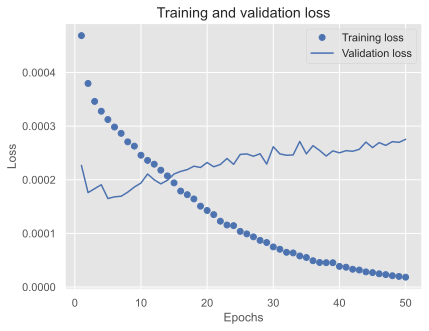

In [147]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [149]:
# Evaluate the model on test data
valid_loss, valid_mse = model.evaluate(x_valid_array, y_valid_array)

print("Test Loss:", valid_loss)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3243e-04 - mean_squared_error: 3.3243e-04 
Test Loss: 0.0002753874578047544
Test Mean Squared Error: 0.0002753874578047544


The results are the same, with the same conclusions as before. Moreover, they are slightly better, indicating the necessity of this method among the previous one.

**RNN**

In [150]:
model = models.Sequential()
model.add(layers.SimpleRNN(128, input_shape=(None, 768), return_sequences=True))
model.add(layers.SimpleRNN(64, return_sequences=True))
model.add(layers.SimpleRNN(32))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

c:\Users\juanl\Documents\Master\2o cuatri\ADNE\Trabajo\Tik Tok\tiktok\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_3 (SimpleRNN)        │ (None, None, 128)      │       114,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ (None, None, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,305 (509.00 KB)

 Trainable params: 130,305 (509.00 KB)

 Non-trainable params: 0 (0.00 B)

In [151]:
# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss=losses.mean_squared_error)  # Using mean squared error loss for regression

In [152]:
# Expandir la dimensión de la entrada
x_train_rnn = np.expand_dims(x_train, axis=1)
x_valid_rnn = np.expand_dims(x_valid, axis=1)

In [153]:
# Train the model
history = model.fit(x_train_rnn,
                    y_train,  
                    epochs=100, batch_size=32, 
                    validation_data=(x_valid_rnn, y_valid))

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.2116 - mean_squared_error: 0.2116 - val_loss: 0.0885 - val_mean_squared_error: 0.0885
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0670 - mean_squared_error: 0.0670 - val_loss: 0.0247 - val_mean_squared_error: 0.0247
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0194 - mean_squared_error: 0.0194 - val_loss: 0.0100 - val_mean_squared_error: 0.0100
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0055 - val_mean_squared_error: 0.0055
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0020 - v

In [154]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])

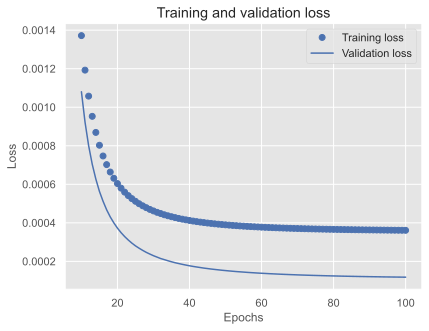

In [155]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(10, len(loss) + 1) # It starts on 10 to see in more detail the majority of epochs

# "bo" is for "blue dot"
plt.plot(epochs, loss[epochs[0]-1:], 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss[epochs[0]-1:], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [157]:
# Evaluate the model on test data
valid_loss, valid_mse = model.evaluate(x_valid_rnn, y_valid)

print("Test Loss:", valid_loss)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6527e-04 - mean_squared_error: 1.6527e-04 
Test Loss: 0.00011784880189225078
Test Mean Squared Error: 0.00011784880189225078


Once again, the results obtained are more or less the same, despite changinghidden layers or hyperparameters.

**LSTM**

In [158]:
model = models.Sequential()
model.add(layers.LSTM(128, input_shape=(None, 768), return_sequences=True))
model.add(layers.LSTM(128, return_sequences=True))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

c:\Users\juanl\Documents\Master\2o cuatri\ADNE\Trabajo\Tik Tok\tiktok\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, None, 128)      │       459,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, None, 128)      │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, None, 64)       │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, None, 64)       │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 685,729 (2.62 MB)

 Trainable params: 685,729 (2.62 MB)

 Non-trainable params: 0 (0.00 B)

In [159]:
# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss=losses.mean_squared_error)  # Using mean squared error loss for regression

In [160]:
# Train the model
history = model.fit(x_train_rnn,
                    y_train,  
                    epochs=100, batch_size=16, 
                    validation_data=(x_valid_rnn, y_valid))

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.2458 - mean_squared_error: 0.2458 - val_loss: 0.2432 - val_mean_squared_error: 0.2432
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2415 - mean_squared_error: 0.2415 - val_loss: 0.2356 - val_mean_squared_error: 0.2356
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2299 - mean_squared_error: 0.2299 - val_loss: 0.1950 - val_mean_squared_error: 0.1950
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1551 - mean_squared_error: 0.1551 - val_loss: 0.0275 - val_mean_squared_error: 0.0275
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0166 - mean_squared_error: 0.0166 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0013 - v

In [161]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])

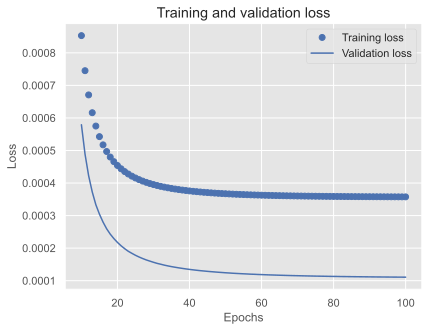

In [162]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(10, len(loss) + 1) # It starts on 10 to see in more detail the majority of epochs

# "bo" is for "blue dot"
plt.plot(epochs, loss[epochs[0]-1:], 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss[epochs[0]-1:], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [164]:
# Evaluate the model on test data
valid_loss, valid_mse = model.evaluate(x_valid_rnn, y_valid)

print("Test Loss:", valid_loss)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 1.5925e-04 - mean_squared_error: 1.5925e-04  
Test Loss: 0.00011073851055698469
Test Mean Squared Error: 0.00011073851055698469


After contrasting that all the models has the same results (but with 1500 less dimensions and a much more easier treatment), the next and last step of this two approaches will be the use of pretrained models, with the aim of checking whether a barrier has been reached in which, with the information available, the prediction of virality cannot be improved further.

#### Deep learning pre-trained models

In [165]:
# Load pre-trained model and tokenizer

from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoConfig

tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
model = AutoModelForMaskedLM.from_pretrained("xlm-roberta-base")

config = AutoConfig.from_pretrained("xlm-roberta-base")

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [166]:
model

XLMRobertaForMaskedLM(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
  

In [167]:
# Select only the encoder/decoder layer and modify the output layer for regression
model.config.num_labels = 1  # Change the number of output labels to 1 for regression
model.lm_head.decoder = nn.Linear(model.config.hidden_size, 1)  # Replace the classifier with a regression layer

In this case it is not necessary to change the embedding model, because it is going to be used the sentences stored in the database ``train_df['all_text']``.

In [168]:
model

XLMRobertaForMaskedLM(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
  

In [169]:
num_layers_to_unfreeze = 0  # For example, unfreeze the top 3 layers

# Freeze all parameters initially
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the top layers
for name, param in model.named_parameters():
    if 'encoder.layer' in name:
        layer_num = int(name.split('.')[3])
        if layer_num >= (12 - num_layers_to_unfreeze):  # Only unfreeze specified number of layers
            param.requires_grad = True    
    
for param in model.lm_head.parameters():
    param.requires_grad = True 
            
# Count the number of trainable parameters
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters after unfreezing layers:", total_trainable_params)  


# With 1 layer unfrozen, there are more than 7M trainable parameters
# It has been tested that the number of paramters of the last layer is the same

Number of trainable parameters after unfreezing layers: 842899


In [170]:
train_df = train_df.reset_index(drop=True)
validation_df = validation_df.reset_index(drop=True)    
    
# Define your dataset and dataloader
train_dataset = CustomDataset(train_df['all_text'], train_df['norm_virality'], tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

valid_dataset = CustomDataset(validation_df['all_text'], validation_df['norm_virality'], tokenizer)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [174]:
# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

num_epochs = 10  # Example number of epochs, adjust as needed

best_val_loss = float('inf')  # Initialize with a large value

# Ensure the directory exists before saving the model
best_model_dir = os.path.join(root_dir, model_path)
os.makedirs(best_model_dir, exist_ok=True)

best_model_path = os.path.join(best_model_dir, "best_model.pth")  # Path to save the best model

# Lists to store training and validation losses
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_train_losses = []  # Store losses for this epoch
    for input_ids, attention_mask, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits.mean(dim=1).squeeze(-1)
        loss = criterion(logits, labels.float())  # Calculate loss
        loss.backward()
        optimizer.step()
        epoch_train_losses.append(loss.item())  # Store loss value for this batch
    
    # Calculate mean training loss and MSE for this epoch
    mean_train_loss = np.mean(epoch_train_losses)
    
    train_losses.append(mean_train_loss)

    # Validation loop
    model.eval()
    epoch_val_losses = []  # Store losses for this epoch

    with torch.no_grad():
        for input_ids, attention_mask, labels in valid_dataloader:
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits.mean(dim=1).squeeze(-1)
            loss = criterion(logits, labels.float())  # Calculate loss
            epoch_val_losses.append(loss.item())  # Store loss value

    # Calculate mean validation loss and MSE for this epoch
    mean_val_loss = np.mean(epoch_val_losses)
    
    val_losses.append(mean_val_loss)

    # Print training and validation metrics
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {mean_train_loss:.4f}, Validation Loss: {mean_val_loss:.4f}")
    
    # Check if current validation loss is better than the best validation loss so far
    if mean_val_loss < best_val_loss:
        # Update best validation loss
        best_val_loss = mean_val_loss
        # Save the model
        torch.save(model.state_dict(), best_model_path)
        print("Best model saved at epoch:", epoch+1)

Epoch 1/10, Train Loss: 0.0092, Train MSE: 0.0096, Validation Loss: 0.0063, Validation MSE: 0.0062
Best model saved at epoch: 1
Epoch 2/10, Train Loss: 0.0025, Train MSE: 0.0027, Validation Loss: 0.0028, Validation MSE: 0.0032
Best model saved at epoch: 2
Epoch 3/10, Train Loss: 0.0020, Train MSE: 0.0020, Validation Loss: 0.0024, Validation MSE: 0.0027
Best model saved at epoch: 3
Epoch 4/10, Train Loss: 0.0017, Train MSE: 0.0018, Validation Loss: 0.0038, Validation MSE: 0.0040
Epoch 5/10, Train Loss: 0.0022, Train MSE: 0.0022, Validation Loss: 0.0020, Validation MSE: 0.0023
Best model saved at epoch: 5
Epoch 6/10, Train Loss: 0.0017, Train MSE: 0.0019, Validation Loss: 0.0023, Validation MSE: 0.0025
Epoch 7/10, Train Loss: 0.0015, Train MSE: 0.0015, Validation Loss: 0.0020, Validation MSE: 0.0023
Best model saved at epoch: 7
Epoch 8/10, Train Loss: 0.0013, Train MSE: 0.0013, Validation Loss: 0.0017, Validation MSE: 0.0019
Best model saved at epoch: 8
Epoch 9/10, Train Loss: 0.0012, Tr

The model saved will not be in the github repo due to its size (over 1GB).

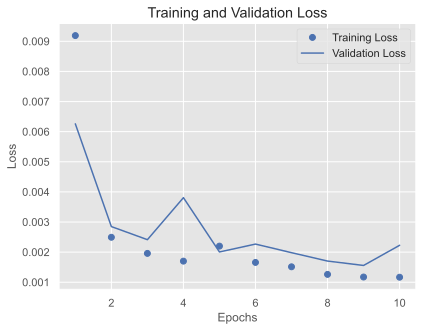

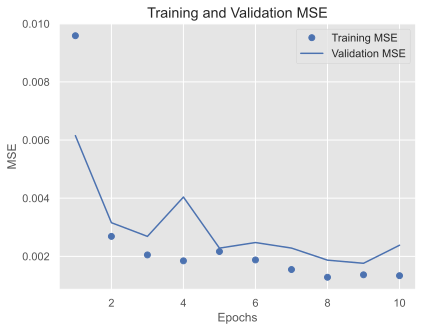

In [175]:
# Plot training and validation losses
epochs = range(1, num_epochs + 1)

plt.plot(epochs, train_losses, 'bo', label='Training Loss')
plt.plot(epochs, val_losses, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The results seems to be 10 times worse than with the previous LSTM (maybe it needs more epochs or a change in the learning rate, batch size, type of model, final hidden layers, etc.), so the next and final step before the third approach would be to perform fine-tuning of this network, unfreezing the last layers for the case that concerns us, together with an optimization of the hyperparameters. However, this requires resources that we do not have, such as GPU. Even without fine-tuning and only 10 epochs, the execution time goes above 120 minutes (2 hours), so it is not possible to train it properly without GPU, unless you are willing to wait for days.

For that reason, it is going to be trained a last model with only 1 unfreezed layer, no hyperparameter optimization and only 5 epochs.

In [178]:
num_layers_to_unfreeze = 1  # For example, unfreeze the top 3 layers

# Freeze all parameters initially
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the top layers
for name, param in model.named_parameters():
    if 'encoder.layer' in name:
        layer_num = int(name.split('.')[3])
        if layer_num >= (12 - num_layers_to_unfreeze):  # Only unfreeze specified number of layers
            param.requires_grad = True    
    
for param in model.lm_head.parameters():
    param.requires_grad = True 
            
# Count the number of trainable parameters
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters after unfreezing layers:", total_trainable_params)  


# With 1 layer unfrozen, there are more than 7M trainable parameters
# It has been tested that the number of paramters of the last layer is the same

Number of trainable parameters after unfreezing layers: 7930771


In [ ]:
# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

num_epochs = 5  # Example number of epochs, adjust as needed

best_val_loss = float('inf')  # Initialize with a large value

# Ensure the directory exists before saving the model
best_model_dir = os.path.join(root_dir, model_path)
os.makedirs(best_model_dir, exist_ok=True)

best_model_path = os.path.join(best_model_dir, "best_model2.pth")  # Path to save the best model

# Lists to store training and validation losses
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_train_losses = []  # Store losses for this epoch

    for input_ids, attention_mask, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits.mean(dim=1).squeeze(-1)
        loss = criterion(logits, labels.float())  # Calculate loss
        loss.backward()
        optimizer.step()
        epoch_train_losses.append(loss.item())  # Store loss value for this batch

    
    # Calculate mean training loss and MSE for this epoch
    mean_train_loss = np.mean(epoch_train_losses)
    
    train_losses.append(mean_train_loss)

    # Validation loop
    model.eval()
    epoch_val_losses = []  # Store losses for this epoch

    with torch.no_grad():
        for input_ids, attention_mask, labels in valid_dataloader:
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits.mean(dim=1).squeeze(-1)
            loss = criterion(logits, labels.float())  # Calculate loss
            epoch_val_losses.append(loss.item())  # Store loss value

    # Calculate mean validation loss and MSE for this epoch
    mean_val_loss = np.mean(epoch_val_losses)
    
    val_losses.append(mean_val_loss)

    # Print training and validation metrics
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {mean_train_loss:.4f}, Validation Loss: {mean_val_loss:.4f}")
    
    # Check if current validation loss is better than the best validation loss so far
    if mean_val_loss < best_val_loss:
        # Update best validation loss
        best_val_loss = mean_val_loss
        # Save the model
        torch.save(model.state_dict(), best_model_path)
        print("Best model saved at epoch:", epoch+1)

In [ ]:
# Plot training and validation losses
epochs = range(1, num_epochs + 1)

plt.plot(epochs, train_losses, 'bo', label='Training Loss')
plt.plot(epochs, val_losses, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Third approach

This last idea will not be developed, since many models have already been made and the objective of this part of the work was to work with text. However, models such as XGBoost or MLP (universal approximators with a lot of predictive potential) could be created and, using the features extracted through sentiments and OHE from hashtags, the results could be also precise.

With this the text notebook ends, leaving the pre-trained model for embedding that contains all the sentences as the best model, then checking its performance on the test set.

## Text Model Testing

In [ ]:
# After training, load the best model for evaluation
best_model = AutoModelForMaskedLM.from_pretrained("xlm-roberta-base")
best_model.load_state_dict(torch.load(best_model_path))